In [1]:
import numpy as np
import whisper_timestamped
import librosa
import python_speech_features as psf
import os
import json
import sys
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import pickle as pkl
from scipy.special import softmax
from torchmetrics.classification import BinaryF1Score, F1Score
from torchmetrics.classification import Accuracy, Precision, Recall
from scipy.interpolate import interp1d
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Desktop/openpose/python/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/EvansToolBox/Utils/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/Gaze_project/')

from Signal_processing_utils import intensity_from_signal
from prototypes.Gaze_aversion_prior.Evan_model import Aversion111Prior
from Dataset_Util.dataloader import Aversion_SelfTap111

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [41]:
%load_ext autoreload
%autoreload 1
%aimport prototypes.Gaze_aversion_prior.Evan_model
%aimport Signal_processing_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class SentenceBaseline_GazePredictionModel(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_GazePredictionModel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)        
        # output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], config["output_layer_3_hidden"])
        self.output_layer_3 = nn.Sequential(self.output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_self[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_self(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # bn
        # x = self.bn(out.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.activation(out)
        x = self.output_layer_1(x)
        x = self.output_layer_2(x)
        x = self.output_layer_3(x)
        return x
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)


# Get dataset, model configs and etc.

In [4]:
dataset_location = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset"
shot_dataset_location = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
model_save_location = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models"

In [5]:
# do the training test split here:
dataset_metadata = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/video_to_window_metadata.json"
dataset_metadata = json.load(open(dataset_metadata, "r"))
all_videos = list(dataset_metadata.keys())
training_set = []
testing_set = []
# get the name of the videos (this ensures no contamination because the same shot is split)
for i in range(0, len(all_videos)):
    if i / len(all_videos) < 0.9:
        training_set.append(all_videos[i])
    else:
        testing_set.append(all_videos[i])

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words/config.json", "r"))
# obtain the dataset
torch.set_default_tensor_type(torch.DoubleTensor)
validation_dataset = Aversion_SelfTap111(dataset_location, testing_set, sentence_and_word_timing=True)
train_dataset = Aversion_SelfTap111(dataset_location, training_set, sentence_and_word_timing=True)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, config['batch_size'], True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, config['batch_size'], True)
model = SentenceBaseline_GazePredictionModel(config)
checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words/best.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(pretrained_dict)
model.to(device)
# train_model(model, config, train_dataloader, valid_dataloader, run_obj, model_save_location)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.



SentenceBaseline_GazePredictionModel(
  (activation): Sigmoid()
  (input_layer_self): Linear(in_features=71, out_features=16, bias=True)
  (input_layer_other): Linear(in_features=71, out_features=16, bias=True)
  (lstm): LSTM(44, 256, batch_first=True)
  (output_layer_1): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_3): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
)

# Evaluate Performance on short clips (10 second clips)

In [34]:
f1_score = F1Score(task="multiclass", num_classes=2, average="weighted").to(device)
accuracy = Accuracy(task="multiclass", num_classes=2, average="weighted").to(device)
precision = Precision(task="multiclass", num_classes=2, average="weighted").to(device)
recall = Recall(task="multiclass", num_classes=2, average="weighted").to(device)
valid_batch_counter = 0
total_valid_f1 = 0
total_valid_acc = 0
total_valid_precision = 0
total_valid_recall = 0

for _, (X, Y) in enumerate(valid_dataloader):
    with torch.no_grad():
        valid_batch_counter += X.size()[0]
        X, Y = X.to(device), Y.to(device)
        if "Transformer" in config["model_type"]:
            all_zero = torch.zeros(Y.shape).to(device)
            pred = model(X, all_zero)
        else:
            pred = model(X)
        # binary_pred = torch.round(pred)
        binary_pred = torch.argmax(pred, axis=2, keepdim=True)
        f1_valid = f1_score(binary_pred, torch.unsqueeze(Y, axis=2)).item()
        accuracy_valid = accuracy(binary_pred, torch.unsqueeze(Y, axis=2)).item()
        recall_valid = recall(binary_pred, torch.unsqueeze(Y, axis=2)).item()
        precision_valid = precision(binary_pred, torch.unsqueeze(Y, axis=2)).item()
        total_valid_f1 += f1_valid * X.size()[0]
        total_valid_acc += accuracy_valid * X.size()[0]
        total_valid_precision += precision_valid * X.size()[0]
        total_valid_recall += recall_valid * X.size()[0]
        del X, Y, pred
        torch.cuda.empty_cache()

In [35]:
print("The f1 score is {}".format(total_valid_f1/valid_batch_counter))
print("The average accuracy is {}".format(total_valid_acc/valid_batch_counter))
print("The average precision is {}".format(total_valid_precision/valid_batch_counter))
print("The average recall is {}".format(total_valid_recall/valid_batch_counter))

The f1 score is 0.9299975216986137
The average accuracy is 0.9303207190669313
The average precision is 0.9303354582703148
The average recall is 0.9303207190669313


### See if uncertainty happens at the start of the video for the 10 second clips

In [33]:
location_of_error_validation = []
valid_batch_counter = 0
for _, (X, Y) in enumerate(valid_dataloader):
    with torch.no_grad():
        valid_batch_counter += X.size()[0]
        X, Y = X.to(device), Y.to(device)
        if "Transformer" in config["model_type"]:
            all_zero = torch.zeros(Y.shape).to(device)
            pred = model(X, all_zero)
        else:
            pred = model(X)
        # binary_pred = torch.round(pred)
        binary_pred = torch.argmax(pred, axis=2, keepdim=True)
        binary_pred = binary_pred.cpu().detach().numpy()
        Y = Y.cpu().detach().numpy()
        for i in range(0, Y.shape[0]):
            for j in range(0, Y.shape[1]):
                if Y[i, j] != binary_pred[i, j, 0]:
                    location_of_error_validation.append(j/25)
        del X, Y, pred
        torch.cuda.empty_cache()

In [26]:
location_of_error_train = []
valid_batch_counter = 0
for _, (X, Y) in enumerate(train_dataloader):
    with torch.no_grad():
        valid_batch_counter += X.size()[0]
        X, Y = X.to(device), Y.to(device)
        if "Transformer" in config["model_type"]:
            all_zero = torch.zeros(Y.shape).to(device)
            pred = model(X, all_zero)
        else:
            pred = model(X)
        # binary_pred = torch.round(pred)
        binary_pred = torch.argmax(pred, axis=2, keepdim=True)
        binary_pred = binary_pred.cpu().detach().numpy()
        Y = Y.cpu().detach().numpy()
        for i in range(0, Y.shape[0]):
            for j in range(0, Y.shape[1]):
                if Y[i, j] != binary_pred[i, j, 0]:
                    location_of_error_train.append(j/25)
        del X, Y, pred
        torch.cuda.empty_cache()

In [27]:
location_of_error_validation = np.array(location_of_error_validation)
location_of_error_train = np.array(location_of_error_train)

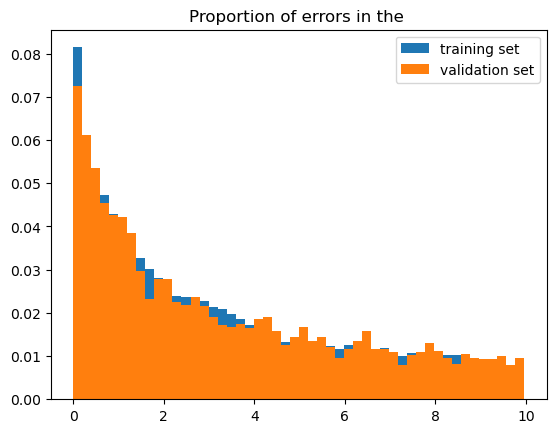

In [28]:
plt.title("Proportion of errors in the ")
weights = np.ones_like(location_of_error_train)/len(location_of_error_train)
plt.hist(location_of_error_train, 50,label = "training set", weights=weights)
weights = np.ones_like(location_of_error_validation)/len(location_of_error_validation)
plt.hist(location_of_error_validation, 50, label = "validation set", weights=weights)
plt.legend()

# Longer Clips Performance

## See the model's performance on longer clips (f1, accuracy, precision recall)

In [7]:
# do the training test split here:
dataset_metadata = os.path.join(*[shot_dataset_location, "metadata.json"])
dataset_metadata = json.load(open(dataset_metadata, "r"))["data"]
# all_videos = list(dataset_metadata.keys())
training_set = []
testing_set = []
# get the name of the videos (this ensures no contamination because the same shot is split)
for i in range(0, len(dataset_metadata)):
    if i / len(dataset_metadata) < 0.9:
        training_set.append(i)
    else:
        testing_set.append(i)

In [8]:
k = Aversion111Prior()

In [9]:
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
# this will probably take forever to run in the first time (40 minutes ish)
f1_score = F1Score(task="multiclass", num_classes=2, average="weighted").to(device)
accuracy = Accuracy(task="multiclass", num_classes=2, average="weighted").to(device)
precision = Precision(task="multiclass", num_classes=2, average="weighted").to(device)
recall = Recall(task="multiclass", num_classes=2, average="weighted").to(device)
valid_batch_counter = 0
total_valid_f1 = 0
total_valid_acc = 0
total_valid_precision = 0
total_valid_recall = 0
for i in range(0, len(training_set)):
    # get output
    input_file_name = dataset_metadata[training_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0)
    valid_batch_counter += out.shape[0]
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[training_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    out = np.where(out >= 0.5, 1, 0)[:, 1]
    out = np.expand_dims(out, 0)
    gaze_label_target = np.expand_dims(gaze_label_target, 0)
    # gaze_label_target = np.expand_dims(gaze_label_target, axis=1)
    f1_valid = f1_score(torch.from_numpy(out).type('torch.FloatTensor').to(device), torch.from_numpy(gaze_label_target).to(device))
    accuracy_valid = accuracy(torch.from_numpy(out).type('torch.FloatTensor').to(device), torch.from_numpy(gaze_label_target).to(device)).item()
    recall_valid = recall(torch.from_numpy(out).type('torch.FloatTensor').to(device), torch.from_numpy(gaze_label_target).to(device)).item()
    precision_valid = precision(torch.from_numpy(out).type('torch.FloatTensor').to(device), torch.from_numpy(gaze_label_target).to(device)).item()
    total_valid_f1 += f1_valid * out.shape[1]
    total_valid_acc += accuracy_valid * out.shape[1]
    total_valid_precision += precision_valid * out.shape[1]
    total_valid_recall += recall_valid * out.shape[1]



KeyboardInterrupt: 

In [18]:
print("The f1 score is {}".format(total_valid_f1/valid_batch_counter))
print("The average accuracy is {}".format(total_valid_acc/valid_batch_counter))
print("The average precision is {}".format(total_valid_precision/valid_batch_counter))
print("The average recall is {}".format(total_valid_recall/valid_batch_counter))

The f1 score is 0.1127763485385685
The average accuracy is 0.11187833369216435
The average precision is 0.11642149720132305
The average recall is 0.11187833369216435


## See this distribution of errors

In [10]:
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
# this will probably take forever to run in the first time (40 minutes ish)
error_distribution_in_time = []
for i in range(0, len(training_set)):
    # get output
    input_file_name = dataset_metadata[training_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0)
    valid_batch_counter += out.shape[0]
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[training_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    out = np.where(out[:, 1] >= 0.5, 1, 0)
    for i in range(0, out.shape[0]):
        if out[i] != gaze_label_target[i]:
            error_distribution_in_time.append(i/25)




In [11]:
error_distribution_in_time_validation = []
for i in range(0, len(testing_set)):
    # get output
    input_file_name = dataset_metadata[testing_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0)
    valid_batch_counter += out.shape[0]
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[testing_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    out = np.where(out[:, 1] >= 0.5, 1, 0)
    for i in range(0, out.shape[0]):
        if out[i] != gaze_label_target[i]:
            error_distribution_in_time_validation.append(i/25)

100%|██████████| 5191/5191 [00:03<00:00, 1437.94frames/s]


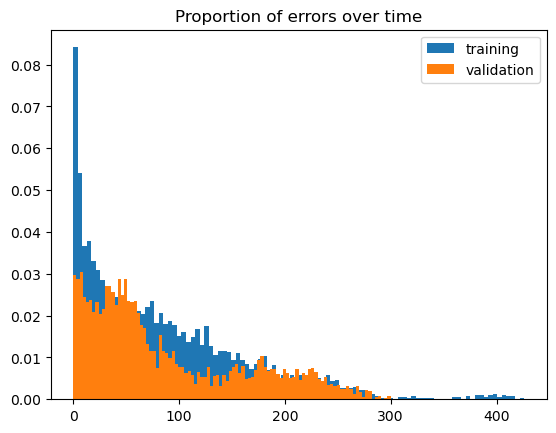

In [14]:
plt.title("Proportion of errors over time")
weights = np.ones_like(error_distribution_in_time)/len(error_distribution_in_time)
plt.hist(error_distribution_in_time, 100,label = "training", weights=weights)
weights = np.ones_like(error_distribution_in_time_validation)/len(error_distribution_in_time_validation)
plt.hist(error_distribution_in_time_validation, 100,label = "validation", weights=weights)
plt.legend()


## See if a Divide and conquer strategy would improve the result

In [32]:
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
# this will probably take forever to run in the first time (40 minutes ish)
f1_score = F1Score(task="multiclass", num_classes=2, average="weighted").to(device)
accuracy = Accuracy(task="multiclass", num_classes=2, average="weighted").to(device)
precision = Precision(task="multiclass", num_classes=2, average="weighted").to(device)
recall = Recall(task="multiclass", num_classes=2, average="weighted").to(device)
valid_batch_counter = 0
total_valid_f1 = 0
total_valid_acc = 0
total_valid_precision = 0
total_valid_recall = 0
k = Aversion111Prior()
for i in range(0, len(training_set)):
    # get output
    input_file_name = dataset_metadata[training_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0, divide_and_conquer=True)
    valid_batch_counter += out.shape[0]
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[training_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    out = np.where(out >= 0.5, 1, 0)[:, 1]
    out = np.expand_dims(out, 0)
    gaze_label_target = np.expand_dims(gaze_label_target, 0)
    # gaze_label_target = np.expand_dims(gaze_label_target, axis=1)
    f1_valid = f1_score(torch.from_numpy(out).type('torch.FloatTensor').to(device), torch.from_numpy(gaze_label_target).to(device))
    accuracy_valid = accuracy(torch.from_numpy(out).type('torch.FloatTensor').to(device), torch.from_numpy(gaze_label_target).to(device)).item()
    recall_valid = recall(torch.from_numpy(out).type('torch.FloatTensor').to(device), torch.from_numpy(gaze_label_target).to(device)).item()
    precision_valid = precision(torch.from_numpy(out).type('torch.FloatTensor').to(device), torch.from_numpy(gaze_label_target).to(device)).item()
    total_valid_f1 += f1_valid * out.shape[1]
    total_valid_acc += accuracy_valid * out.shape[1]
    total_valid_precision += precision_valid * out.shape[1]
    total_valid_recall += recall_valid * out.shape[1]



In [33]:
print("The f1 score is {}".format(total_valid_f1/valid_batch_counter))
print("The average accuracy is {}".format(total_valid_acc/valid_batch_counter))
print("The average precision is {}".format(total_valid_precision/valid_batch_counter))
print("The average recall is {}".format(total_valid_recall/valid_batch_counter))

The f1 score is 0.8054374882069837
The average accuracy is 0.7962021562490547
The average precision is 0.8429124332480613
The average recall is 0.7962021562490547


In [34]:
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
# this will probably take forever to run in the first time (40 minutes ish)
error_distribution_in_time = []
for i in range(0, len(training_set)):
    # get output
    input_file_name = dataset_metadata[training_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0, divide_and_conquer=True)
    valid_batch_counter += out.shape[0]
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[training_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    out = np.where(out[:, 1] >= 0.5, 1, 0)
    for i in range(0, out.shape[0]):
        if out[i] != gaze_label_target[i]:
            error_distribution_in_time.append(i/25)
error_distribution_in_time_validation = []
for i in range(0, len(testing_set)):
    # get output
    input_file_name = dataset_metadata[testing_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0, divide_and_conquer=True)
    valid_batch_counter += out.shape[0]
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[testing_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    out = np.where(out[:, 1] >= 0.5, 1, 0)
    for i in range(0, out.shape[0]):
        if out[i] != gaze_label_target[i]:
            error_distribution_in_time_validation.append(i/25)



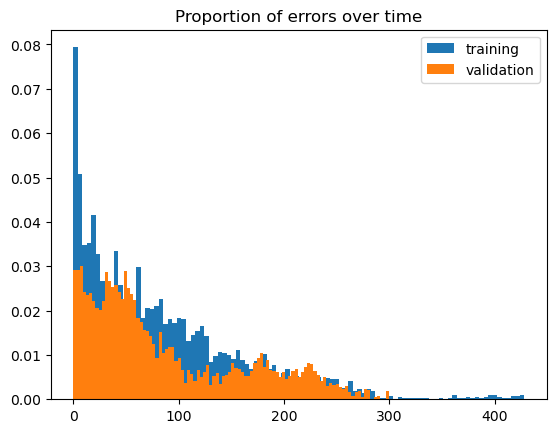

In [35]:
plt.title("Proportion of errors over time")
weights = np.ones_like(error_distribution_in_time)/len(error_distribution_in_time)
plt.hist(error_distribution_in_time, 100,label = "training", weights=weights)
weights = np.ones_like(error_distribution_in_time_validation)/len(error_distribution_in_time_validation)
plt.hist(error_distribution_in_time_validation, 100,label = "validation", weights=weights)
plt.legend()


# Evaluate interval statistics

### Length of intervals

In [42]:
from Signal_processing_utils import get_activity_interval, get_binary_intervals

In [54]:
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
# this will probably take forever to run in the first time (40 minutes ish)
length_of_fixation_prediction = []
length_of_fixation_dataset = []
for i in range(0, len(training_set)):
    # get output
    input_file_name = dataset_metadata[training_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0)
    binary_out = np.where(out>0.5, 1, 0)[:, 1]
    out_indexes = np.arange(0, binary_out.shape[0])/25
    intervals = get_binary_intervals(binary_out, out_indexes)
    for tim in intervals:
        length_of_fixation_prediction.append(tim[2] - tim[1])
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[training_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    # print(i, gaze_label_target.shape, binary_out.shape)
    intervals = get_binary_intervals(gaze_label_target, target_ts)
    for tim in intervals:
        length_of_fixation_dataset.append(tim[2] - tim[1])
plt.title("Proportion of gaze_fixation_length")
weights = np.ones_like(length_of_fixation_dataset)/len(length_of_fixation_dataset)
plt.hist(length_of_fixation_dataset, 100,label = "dataset", weights=weights, range=[0, 25])
weights = np.ones_like(length_of_fixation_prediction)/len(length_of_fixation_prediction)
plt.hist(length_of_fixation_prediction, 100,label = "prediction", weights=weights, range=[0, 25], alpha=0.5)
plt.legend()




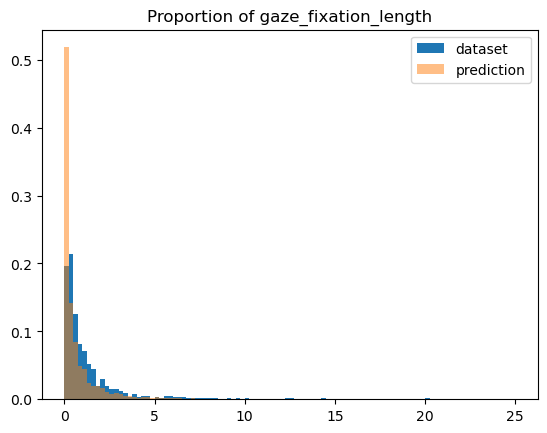

In [60]:
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
# this will probably take forever to run in the first time (40 minutes ish)
length_of_fixation_prediction = []
length_of_fixation_dataset = []
for i in range(0, len(testing_set)):
    # get output
    input_file_name = dataset_metadata[testing_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0)
    binary_out = np.where(out>0.5, 1, 0)[:, 1]
    out_indexes = np.arange(0, binary_out.shape[0])/25
    intervals = get_binary_intervals(binary_out, out_indexes)
    for tim in intervals:
        length_of_fixation_prediction.append(tim[2] - tim[1])
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[testing_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    # print(i, gaze_label_target.shape, binary_out.shape)
    intervals = get_binary_intervals(gaze_label_target, target_ts)
    for tim in intervals:
        length_of_fixation_dataset.append(tim[2] - tim[1])
plt.title("Proportion of gaze_fixation_length")
weights = np.ones_like(length_of_fixation_dataset)/len(length_of_fixation_dataset)
plt.hist(length_of_fixation_dataset, 100,label = "dataset", weights=weights, range=[0, 25])
weights = np.ones_like(length_of_fixation_prediction)/len(length_of_fixation_prediction)
plt.hist(length_of_fixation_prediction, 100,label = "prediction", weights=weights, range=[0, 25], alpha=0.5)
plt.legend()



### Number of intervals

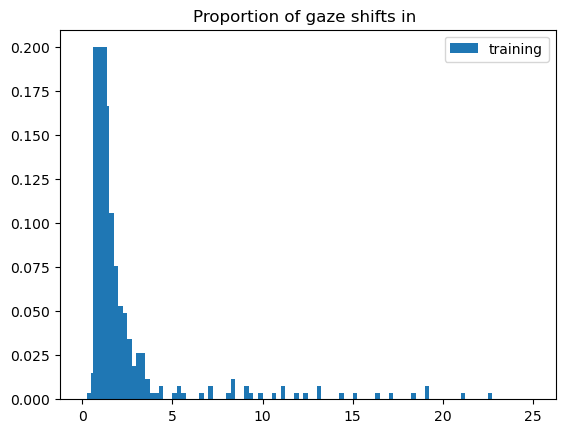

In [62]:
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
# this will probably take forever to run in the first time (40 minutes ish)
count_of_fixation_prediction = []
count_of_fixation_dataset = []
for i in range(0, len(training_set)):
    # get output
    input_file_name = dataset_metadata[training_set[i]]["name"]
    out = k.predict(temp_folder, input_folder, input_file_name, 0)
    binary_out = np.where(out>0.5, 1, 0)[:, 1]
    out_indexes = np.arange(0, binary_out.shape[0])/25
    intervals = get_binary_intervals(binary_out, out_indexes)
    count_of_fixation_prediction.append(len(intervals))
    # get gaze data
    gaze_data_path = os.path.join(input_folder, "aversion_label", input_file_name+".pkl")
    gaze_label = pkl.load(open(gaze_data_path, "rb"))
    gaze_ts = np.arange(0, len(gaze_label))/dataset_metadata[training_set[i]]["fps"]
    target_ts = np.arange(0, out.shape[0])/25
    gaze_label_interp = interp1d(gaze_ts, gaze_label, bounds_error=False, kind='nearest', axis=0, fill_value="extrapolate")
    gaze_label_target = gaze_label_interp(target_ts)
    # print(i, gaze_label_target.shape, binary_out.shape)
    intervals = get_binary_intervals(gaze_label_target, target_ts)
    count_of_fixation_dataset.append(len(intervals))

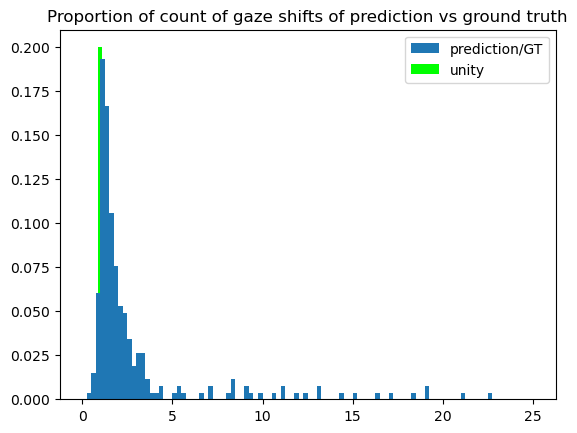

In [70]:
proportion = []
for i in range(0, len(count_of_fixation_dataset)):
    proportion.append(count_of_fixation_prediction[i]/count_of_fixation_dataset[i])
plt.title("Proportion of count of gaze shifts of prediction vs ground truth")
weights = np.ones_like(proportion)/len(proportion)
plt.bar([1], [0.2], color=[0, 1, 0], label="unity", width=0.2)
plt.hist(proportion, 100,label = "prediction/GT", weights=weights, range=[0, 25])
plt.legend()

# Experiment with post-processing

In [76]:
from Signal_processing_utils import runEuro

In [80]:
%matplotlib widget

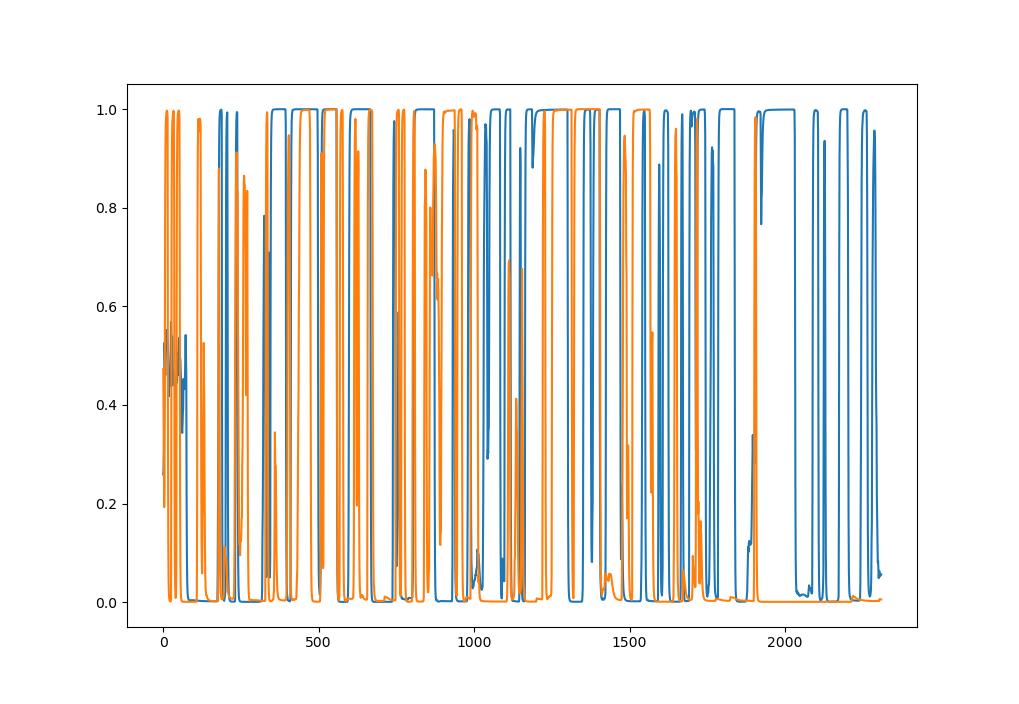

NameError: name 'A' is not defined

In [85]:
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
# this will probably take forever to run in the first time (40 minutes ish)
model = Aversion111Prior()
for i in range(0, len(training_set)):
    input_file_name = dataset_metadata[training_set[i]]["name"]
    # here 0 is aversion
    out = model.predict(temp_folder, input_folder, input_file_name, 0)[:, 0:1]
    t = np.arange(0, out.shape[0])/25.0
    out = runEuro(t, out)
    plt.cla()
    plt.plot(out)
    plt.show()
    A[2]
    